# Simulating the Golenetskii correlation with popsynth

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

import popsynth
from popsynth.aux_samplers.trunc_normal_aux_sampler import TruncatedNormalAuxSampler
from popsynth.aux_samplers.lognormal_aux_sampler import LogNormalAuxSampler

## GRB population

In [29]:
# redshift distribution
r0_true = 1.
rise_true = 1.
decay_true = 4.0
peak_true = 1.5

# luminosity function
Lmin_true = 1e51
alpha_true = 1.5
r_max = 7.0



In [3]:
pop_gen.display()

## Luminosity Function

<IPython.core.display.Math object>

,parameter,value
0,Lmin,1.000000e+51
1,alpha,1.500000e+00


## Spatial Function

<IPython.core.display.Math object>

,parameter,value
0,r0,1.0
1,rise,1.0
2,decay,4.0
3,peak,1.5
4,r_max,7.0


## Auxiliary samplers

In [65]:

class DurationSampler(popsynth.AuxiliarySampler):

    sigma = popsynth.auxiliary_sampler.AuxiliaryParameter(default=1)
    
    def __init__(self):
        """
        samples how long the pulse lasts
        """

        super(DurationSampler, self).__init__(
            name="duration", observed=False
        )

    def true_sampler(self, size):

        t90 = 10 ** self._secondary_samplers["log_t90"].true_values

        self._true_values = 1.5 * t90
        

class LstartSampler(popsynth.DerivedLumAuxSampler):
    """
    L0 sampler
    """
    

    def __init__(self):
        
        super(LstartSampler, self).__init__('L',)
        
    def true_sampler(self, size):
        
        L = 10**self._secondary_samplers["log_L0"].true_values * np.power(10**self._secondary_samplers["log_ep_start"].true_values/300.,self._secondary_samplers["gamma"].true_values  )
        

        self._true_values = L
        
    def compute_luminosity(self):
        
        return self._true_values
        
  

In [95]:
trise = TruncatedNormalAuxSampler(name="trise", observed=False)
trise.lower=0.01
trise.upper=5.0
trise.mu=1
trise.tau=1.0

t90 = popsynth.aux_samplers.NormalAuxSampler(name="log_t90", observed=False)
t90.mu=2
t90.tau=0.1


log_L0 = popsynth.aux_samplers.NormalAuxSampler(name='log_L0')
log_L0.mu = np.log10(1e50)
log_L0.sigma = 1.

gamma = popsynth.aux_samplers.NormalAuxSampler(name='gamma')
gamma.mu = 1.5
gamma.sigma = .1


log_ep_start = popsynth.aux_samplers.NormalAuxSampler(name='log_ep_start')
log_ep_start.mu = 2
log_ep_start.sigma = .1


duration = DurationSampler()

duration.set_secondary_sampler(t90)

lsamp = LstartSampler()
lsamp.set_secondary_sampler(gamma)
lsamp.set_secondary_sampler(log_L0)
lsamp.set_secondary_sampler(log_ep_start)

In [96]:
r0_true = 10
pop_gen = popsynth.populations.ParetoSFRPopulation(
    r0=r0_true,
    rise=rise_true,
    decay=decay_true,
    peak=peak_true,
    Lmin=Lmin_true,
    alpha=alpha_true,
    r_max=r_max,
)

pop_gen.add_observed_quantity(duration)
pop_gen.add_observed_quantity(lsamp)
#pop_gen.add_observed_quantity(log_ep_start)
#pop_gen.add_observed_quantity(log_L0)

registering auxilary sampler: duration
registering derived luminosity sampler: L


## Survey

In [97]:
population = pop_gen.draw_survey(no_selection=True, boundary=1e-2)

The volume integral is 381.111856



Expecting 362 total objects
Sampling: L
L is sampling its secondary quantities
Sampling: gamma
Sampling: log_L0
Sampling: log_ep_start
Getting luminosity from derived sampler
Sampling: duration
duration is sampling its secondary quantities
Sampling: log_t90
Applying soft boundary



No Selection! Added back all objects
NO HIDDEN OBJECTS
Deteced 362 objects or to a distance of 4.99


<IPython.core.display.Javascript object>


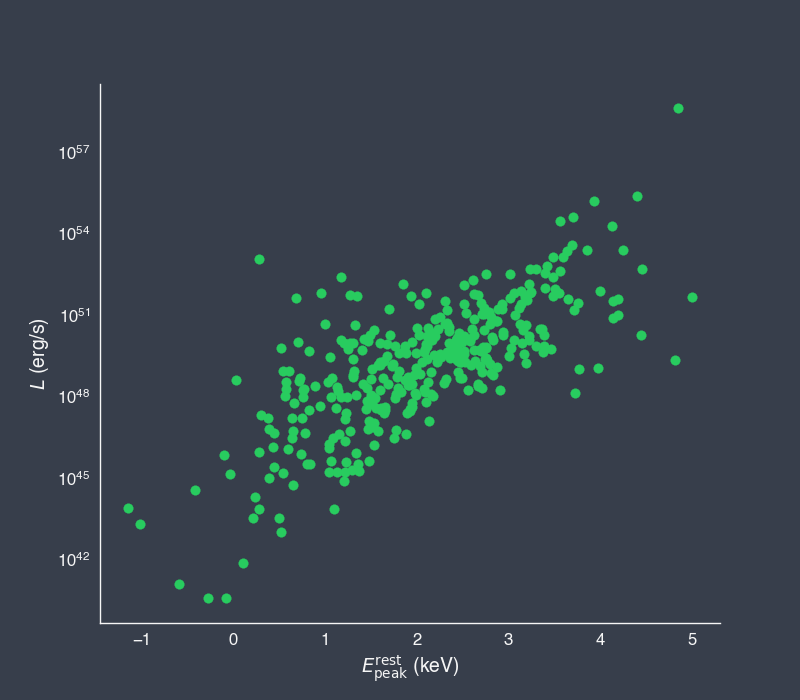

Text(0, 0.5, '$L$ (erg/s)')

In [98]:
fig, ax = plt.subplots()

ax.scatter(population.log_ep_start, population.luminosities)
#ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('$E_\mathrm{peak}^\mathrm{rest}$ (keV)')
ax.set_ylabel('$L$ (erg/s)')

<IPython.core.display.Javascript object>


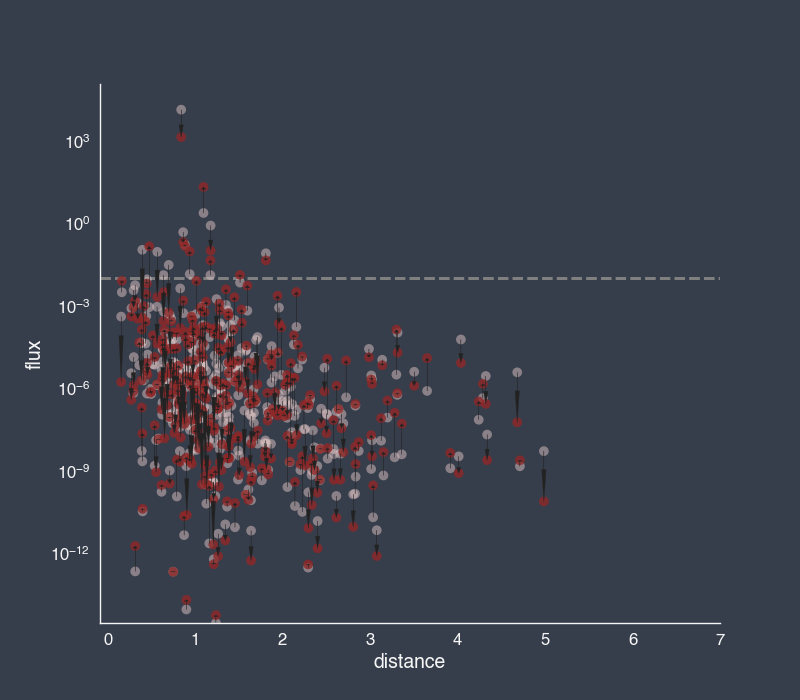

In [81]:
population.display_fluxes();

array([52.04235928, 51.49867095, 50.68899127, 53.47947844, 50.58826713,
       51.13435629, 51.0922892 , 51.30398593, 52.07724385, 51.79512624,
       52.72867874, 51.62727526, 52.50300177, 51.84317681, 50.60312251,
       52.17780744, 52.20138006, 53.13190757, 51.88078267, 51.14965705,
       51.28503305, 53.33048654, 53.21842232, 52.40234567, 51.97954318,
       50.56263388, 51.6164778 , 50.15298175, 51.41255351, 51.95686181,
       51.73993827, 53.07148842, 51.91781537, 52.13882562, 52.29490549,
       53.40269266, 51.37778361, 51.47751303, 52.17797111, 50.81451069,
       51.59522455, 52.23937594, 51.77879355, 52.13241966, 51.95798347,
       50.93872688, 52.0764792 , 53.59921747, 51.48224274, 50.59937751,
       52.53858891, 52.65628239, 51.58631923, 51.03040846, 53.23457607,
       51.86141025, 54.37030628, 51.97774564, 53.03320166, 53.14762898,
       51.92262928, 51.78600113, 52.1950171 , 52.45756252, 52.3548062 ,
       53.95120769, 53.56800797, 53.23256528, 52.17426935, 53.04

In [71]:
population.log_ep_start.max()

5.700116974090916

Text(0, 0.5, '$F_E$ (erg $\\mathrm{s}^{-1}$ $\\mathrm{cm}^{-2}$)')

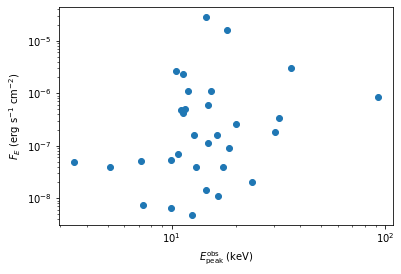

In [9]:
fig, ax = plt.subplots()
ax.scatter(population.Epeak_obs, population.flux_observed_all)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('$E_\mathrm{peak}^\mathrm{obs}$ (keV)')
ax.set_ylabel('$F_E$ (erg $\mathrm{s}^{-1}$ $\mathrm{cm}^{-2}$)')

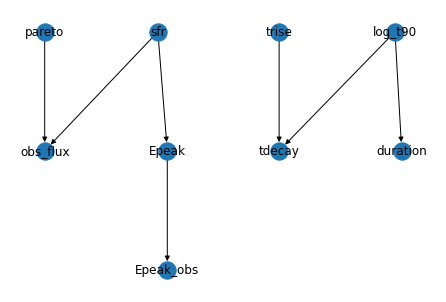

In [10]:
# Graph needs fixing for L-dependence
pos=nx.drawing.nx_agraph.graphviz_layout(pop_gen.graph, prog='dot')

nx.draw(pop_gen.graph, with_labels=True,pos=pos)